In [ ]:
from scipy.integrate import odeint
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
tf.version.VERSION

'2.12.0'

In [ ]:
#Lorenz Parameters (rho = 10, 28, and 40)
sigma = 10
rho = 28
beta = 8/3

#These are initial conditions (we can choose others)
x0 = 0
y0 = 1
z0 = 1

In [ ]:
#The Lorenz equations
def Lorenz(X, t, simga, beta, rho):
    x,y,z = X 
    dxdt = -sigma * (x - y)
    dydt = x * (rho - z) - y
    dzdt = (x * y) - (beta * z)
    return dxdt, dydt, dzdt

In [ ]:
#Maximum time point and total number of time points.
tmax = 100
n = 10000

#Interpolate solution onto the time grid, t.
t = np.linspace(0, tmax, n)

In [ ]:
#Integrate the Lorenz equations.
sol1 = odeint(Lorenz,(x0, y0, z0),t,args=(sigma, beta, rho))

In [ ]:
#Where the first column is composed of the values of x, the second of y and third of z
sol1.shape

(10000, 3)

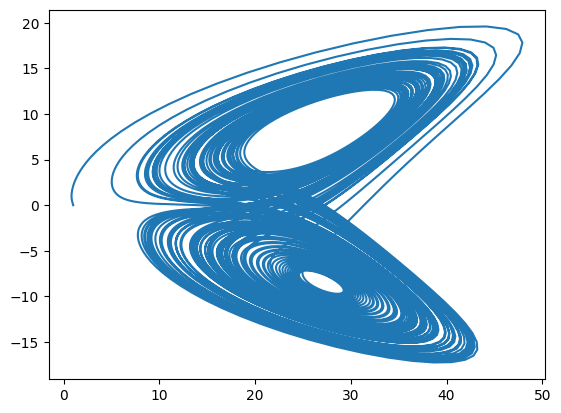

In [ ]:
#You have to stack all of the data with each rho on top of each other into a matrix xn
#You then also have to stack the data for one time stamp in the future into a matrix xnp1
#Then you feed both xn and xnp1 into the model

plt.plot(sol1[:,2], sol1[:, 0], label='x_coord')
plt.savefig("Lorenz_rho28")

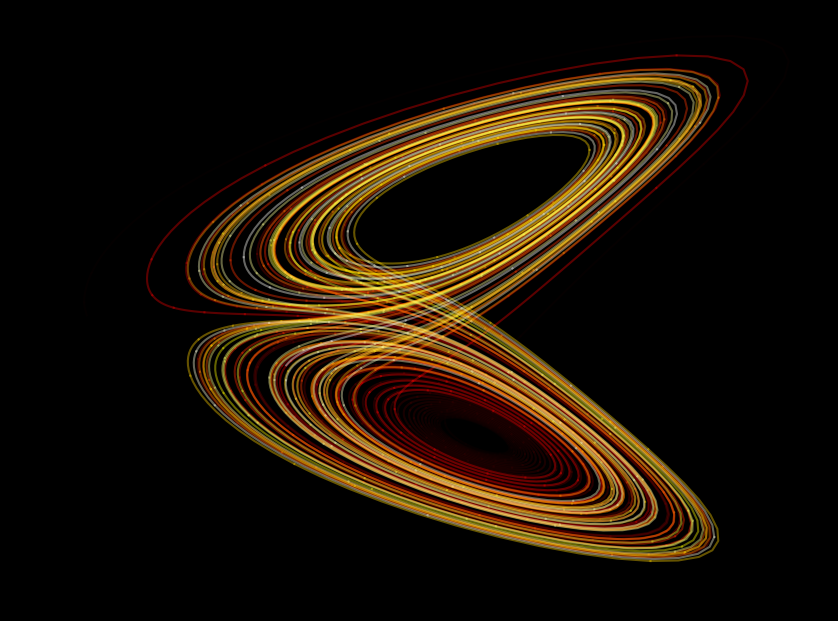

In [ ]:
#A prettier 2D graph, though I still have to figure out the axes
s=10
x=sol1[:, 0]
y=sol1[:, 1]
z=sol1[:, 2]
WIDTH, HEIGHT, DPI = 1000, 750, 100
fig = plt.figure(facecolor='xkcd:black', figsize=(WIDTH/DPI, HEIGHT/DPI))
ax = plt.axes()
ax.set_facecolor('k')
cmap = plt.cm.hot
for i in range(0,n-s,s):
    ax.plot(z[i:i+s+1], x[i:i+s+1], color=cmap(i/n), alpha=0.4)

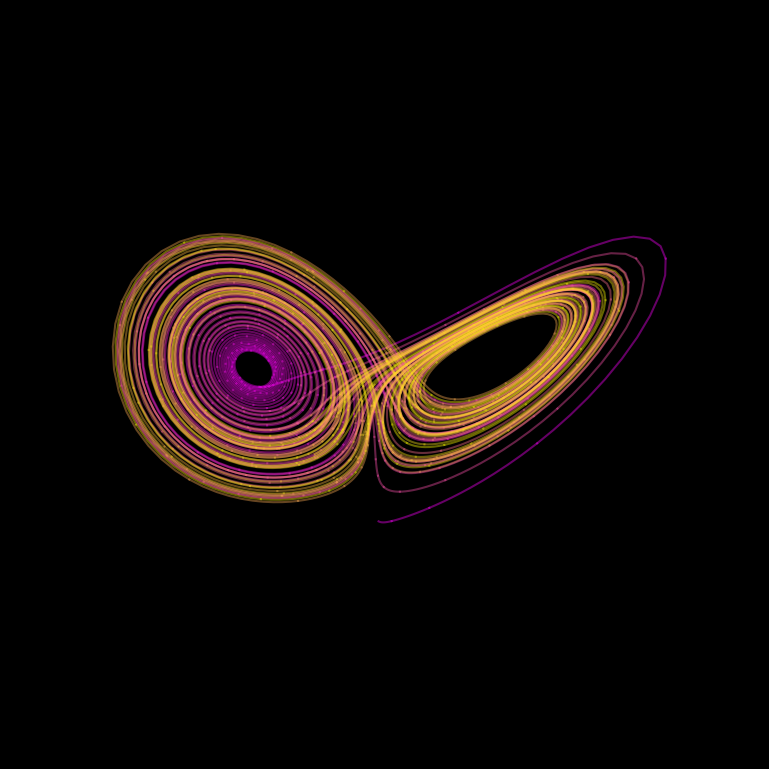

In [ ]:
#Let's us make a 3D graph

WIDTH, HEIGHT, DPI = 1000, 750, 100
fig = plt.figure(facecolor='k', figsize=(WIDTH/DPI, HEIGHT/DPI))
ax = plt.axes(projection='3d')
ax.set_facecolor('k')
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
x= sol1[:, 0]
y=sol1[:, 1]
z=sol1[:,2]
#Make the line multi-coloured by plotting it in segments of length s which
#change in colour across the whole time series.
s = 10
cmap = plt.cm.spring
for i in range(0,n-s,s):
   ax.plot(x[i:i+s+1], y[i:i+s+1], z[i:i+s+1], color=cmap(i/n), alpha=0.4)

#Remove all the axis clutter, leaving just the curve.
ax.set_axis_off()
plt.savefig("Lorenz3DModel")

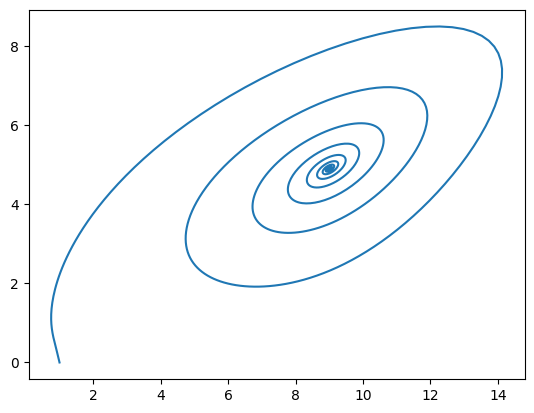

In [ ]:
#Solution of rho = 10
rho = 10
sol2 = odeint(Lorenz,(x0, y0, z0),t,args=(sigma, beta, rho))
plt.plot(sol2[:,2], sol2[:, 0], label='x_coord')
plt.savefig("lorenzrho10")

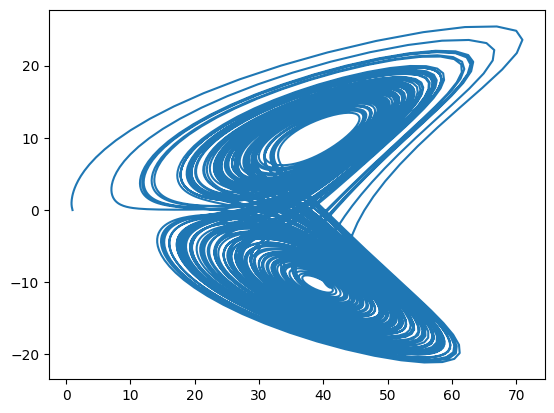

In [ ]:
#Solution of rho = 40
rho = 40
sol3 = odeint(Lorenz,(x0, y0, z0),t,args=(sigma, beta, rho))
plt.plot(sol3[:,2], sol3[:, 0], label='x_coord')
plt.savefig("Lorenzrho40")

In [ ]:
np.save('solutions_rho28', sol1)
np.save('solutions_rho10', sol2)
np.save('solutions_rho40', sol3)

In [ ]:
#Data processing to feed into the mdoel
matrix_rho10 = np.load('/content/solutions_rho10.npy')
matrix_rho28 = np.load('/content/solutions_rho28.npy')
matrix_rho40 = np.load('/content/solutions_rho40.npy')


#That was too complicated! Just get the entire data, all 10,000 x 3 into a matrix and then slice that
size_input = matrix_rho10.shape[0]*3
data = np.empty((size_input,4))
data.shape

#Here we stack our all of our data from each rho into one single matrix "data"
#refactor this to loops because it's really ugly
data[0:10000,0:3] = matrix_rho10
data[10000:20000,0:3] = matrix_rho28
data[20000:30000,0:3] = matrix_rho40
data[0:10000,3:4] = 10
data[10000:20000,3:4] = 28
data[20000:30000,3:4] = 40


#Here we create matrices xn and xnp1 where xnp1 represents the forecast of xn one step into the future
xn = np.empty((9999*3,4))
xn[0:9999,0:4] = data[0:9999,0:4]
xn[9999:19998,0:4] = data[10000:19999,0:4]
xn[19998:29997,0:4] = data[20000:29999,0:4]

xnp1 = np.empty((9999*3,4))
xnp1[0:9999,0:4] = data[1:10000,0:4]
xnp1[9999:19998,0:4] = data[10001:20000,0:4]
xnp1[19998:29997,0:4] = data[20001:30000,0:4]

#Just some testing to make sure that the slicing is done correctly
xnp1[0:1,0:4] == xn[1:2,0:4]
xnp1[9999:10000,0:4] == xn[10000:10001,0:4]
xnp1[19998:19999,0:4] == xn[19999:20000,0:4]
xnp1[20001:20002,0:4] ==xn[20002:20003,0:4]

array([[ True,  True,  True,  True]])

In [ ]:
def init_model(num_hidden_layers = 4, num_neurons_per_layer = 80):
    #Initialize a feedforward neural network
    model = tf.keras.Sequential()

    #Input is 2D - for each component of the Henon output
    model.add(tf.keras.Input(4))

    #Append hidden layers
    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer,
            activation=tf.keras.activations.get('relu'),
            kernel_initializer='glorot_normal'))

    #Output is 2D - for the next step of Henon map
    model.add(tf.keras.layers.Dense(4))
    
    return model

In [ ]:
def compute_loss(model, xn,xnp1, steps): 
#Here you would have instead of xnforward, xn or xnp1 (MSE: Mean square error)
    
    loss = 0
    
    xpred = model(xn)
        
    loss += tf.reduce_mean( tf.square( xpred - xnp1 ) )

    return loss

In [ ]:
def get_grad(model, xn,xnp1, steps): 
#Here you would have instead of xnforward, xn or xnp1
    
    with tf.GradientTape(persistent=True) as tape:
        #This tape is for derivatives with
        #Respect to trainable variables
        tape.watch(model.trainable_variables)
        loss = compute_loss(model, xn,xnp1, steps)

    g = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, g

#Everything below this code should work quite fine for Lorenz

In [ ]:
# Initialize model aka tilde u
model = init_model()

# We choose a piecewise decay of the learning rate, i.e., the
# step size in the gradient descent type algorithm
# the first 1000 steps use a learning rate of 0.01
# from 1000 - 3000: learning rate = 0.001
# from 3000 onwards: learning rate = 0.0005

lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-2,1e-3,1e-4])
#lr = 0.00001

# Choose the optimizer
optim = tf.keras.optimizers.Adam(learning_rate=lr)

In [ ]:
from time import time

steps = 4

#Define one training step as a TensorFlow function to increase speed of training
@tf.function
def train_step():
    #Compute current loss and gradient w.r.t. parameters
    loss, grad_theta = get_grad(model, xn,xnp1, steps)
    
    #Perform gradient descent step
    optim.apply_gradients(zip(grad_theta, model.trainable_variables))
    
    return loss

#Number of training epochs
N = 10000
hist = []

#Start timer
t0 = time()

for i in range(N+1):
    
    loss = train_step()
    
    #Append current loss to hist
    hist.append(loss.numpy())
    
    #Output current loss after 50 iterates
    if i%50 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))
        
#Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

It 00000: loss = 4.80964722e+02
It 00050: loss = 2.40440845e+00
It 00100: loss = 3.97792310e-01
It 00150: loss = 6.83528334e-02
It 00200: loss = 3.80404890e-02
It 00250: loss = 2.78196055e-02
It 00300: loss = 5.83018437e-02
It 00350: loss = 1.90633852e-02
It 00400: loss = 3.89504209e-02
It 00450: loss = 1.65417902e-02
It 00500: loss = 1.35265160e-02
It 00550: loss = 1.82122886e-02
It 00600: loss = 1.24288909e-02
It 00650: loss = 5.66172861e-02
It 00700: loss = 1.11207319e-02
It 00750: loss = 4.30843197e-02
It 00800: loss = 1.14829829e-02
It 00850: loss = 1.00288233e-02
It 00900: loss = 4.50003184e-02
It 00950: loss = 9.62521322e-03
It 01000: loss = 8.79832637e-03
It 01050: loss = 8.72948021e-03
It 01100: loss = 8.67481809e-03
It 01150: loss = 8.62007309e-03
It 01200: loss = 8.56510736e-03
It 01250: loss = 8.51023197e-03
It 01300: loss = 8.45552050e-03
It 01350: loss = 8.40032846e-03
It 01400: loss = 8.34437460e-03
It 01450: loss = 8.28779116e-03
It 01500: loss = 8.23114626e-03
It 01550

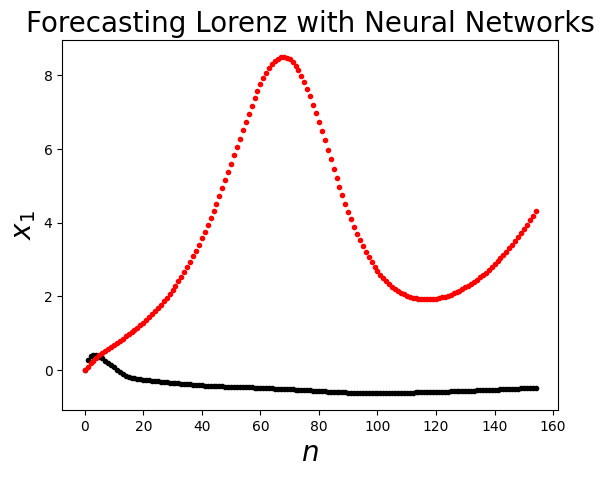

In [ ]:
M = 1000

xpred = np.zeros((M,4))
xpred[0] = xn[0,:]

for m in range(1,M):
    xpred[m] = model(xpred[m-1:m,:])   
    
#Plot Henon Trajectories
fig = plt.figure()
plt.plot(xpred[:155,0],'k.') 
plt.plot(xn[:155,0],'r.') 
plt.title('Forecasting Lorenz with Neural Networks', fontsize = 20)
plt.xlabel('$n$', fontsize = 20)
plt.ylabel('$x_1$', fontsize = 20)  
plt.savefig("forecast1")

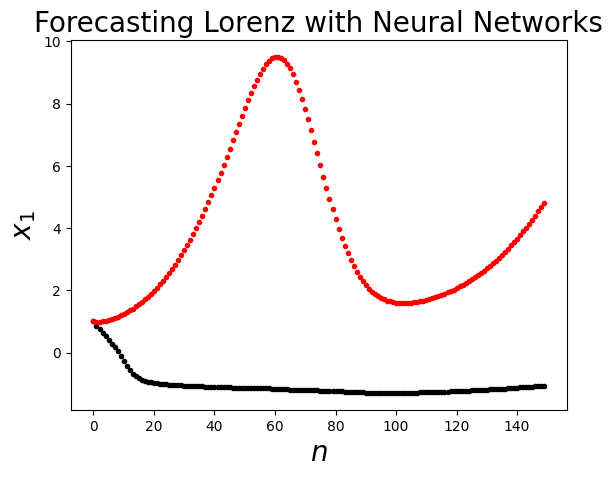

In [ ]:
#Plot Henon Trajectories
fig = plt.figure()
plt.plot(xpred[:150,1],'k.') 
plt.plot(xn[:150,1],'r.') 
plt.title('Forecasting Lorenz with Neural Networks', fontsize = 20)
plt.xlabel('$n$', fontsize = 20)
plt.ylabel('$x_1$', fontsize = 20) 
plt.savefig("forecast2")

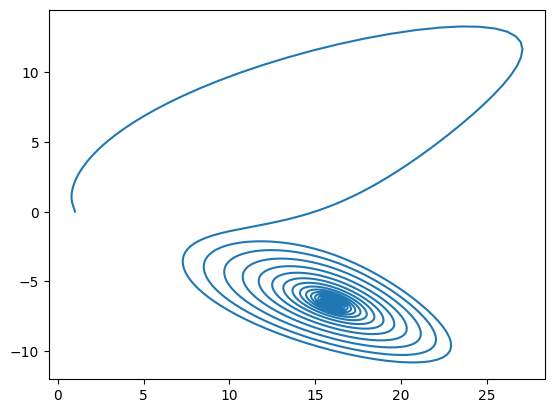

In [ ]:
#Testing the other rho values
rho = 17
sol4 = odeint(Lorenz,(x0, y0, z0),t,args=(sigma, beta, rho))
plt.plot(sol4[:,2], sol4[:, 0], label='x_coord')
plt.savefig("Lorenzrho17")

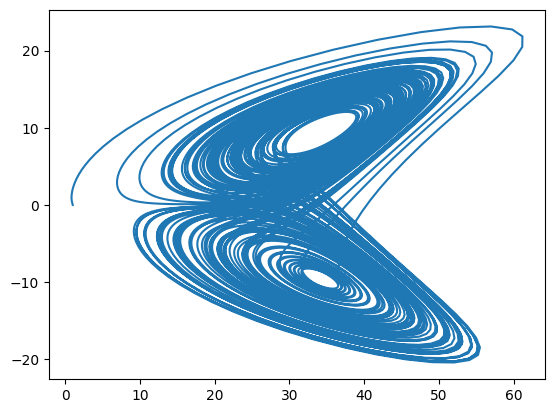

In [ ]:
rho = 35
sol5 = odeint(Lorenz,(x0, y0, z0),t,args=(sigma, beta, rho))
plt.plot(sol5[:,2], sol5[:, 0], label='x_coord')
plt.savefig("Lorenzrho35")

In [ ]:
np.save('solutions_rho17', sol4)
np.save('solutions_rho35', sol5)

In [ ]:
matrix_rho17=np.load('/content/solutions_rho17.npy')
matrix_rho35=np.load('/content/solutions_rho35.npy')

In [ ]:
#rho 17 data
size_input = matrix_rho17.shape[0]*3
dataRho17 = np.empty((size_input,4))
dataRho17[0:10000,0:3] = matrix_rho17
dataRho17[0:10000,3:4] = 17

In [ ]:
#rho 35 data
size_input = matrix_rho35.shape[0]*3
dataRho35 = np.empty((size_input,4))
dataRho35[0:10000,0:3] = matrix_rho35
dataRho35[0:10000,3:4] = 35

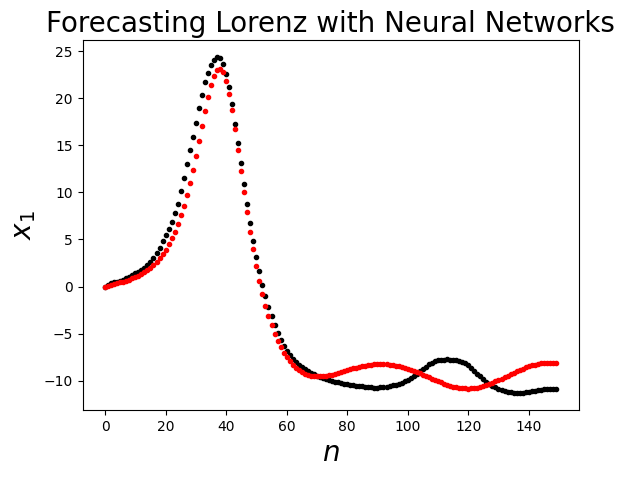

In [ ]:
M = 10000

xpred = np.zeros((M,4))
xpred[0] = dataRho35[0,:]

for m in range(1,M):
    xpred[m] = model(xpred[m-1:m,:])   
    
#Plot Henon Trajectories for rho 35
fig = plt.figure()
plt.plot(xpred[:150,0],'k.') 
plt.plot(dataRho35[:150,0],'r.') 
plt.title('Forecasting Lorenz with Neural Networks', fontsize = 20)
plt.xlabel('$n$', fontsize = 20)
plt.ylabel('$x_1$', fontsize = 20)
plt.savefig("forecast3")

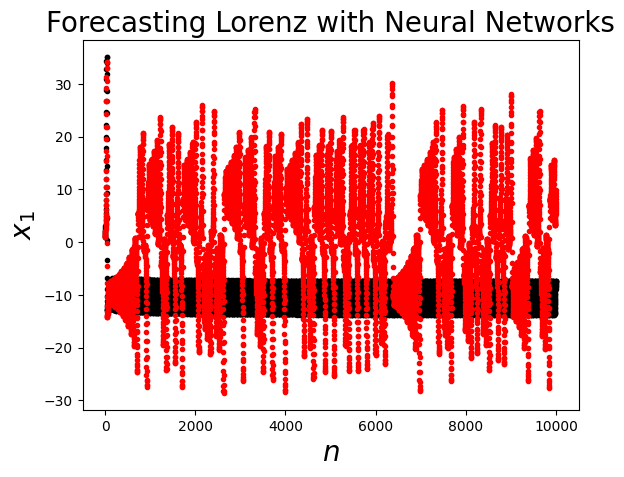

In [ ]:
#Plot Henon Trajectories
fig = plt.figure()
plt.plot(xpred[:10000,1],'k.') 
plt.plot(dataRho35[:10000,1],'r.') 
plt.title('Forecasting Lorenz with Neural Networks', fontsize = 20)
plt.xlabel('$n$', fontsize = 20)
plt.ylabel('$x_1$', fontsize = 20) 
plt.savefig("forecast4") 

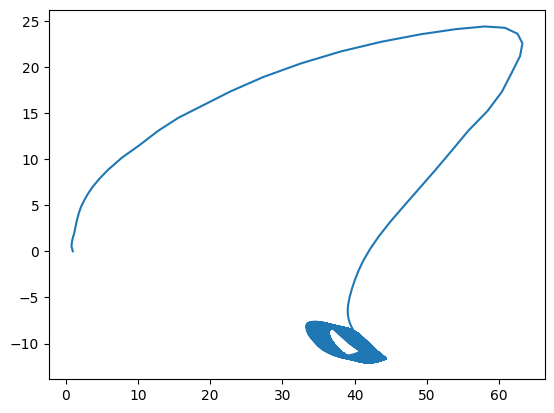

In [ ]:
#Plot of data
plt.plot(xpred[:,2], xpred[:, 0], label='x_coord')
plt.savefig("Lorenzrho35data")

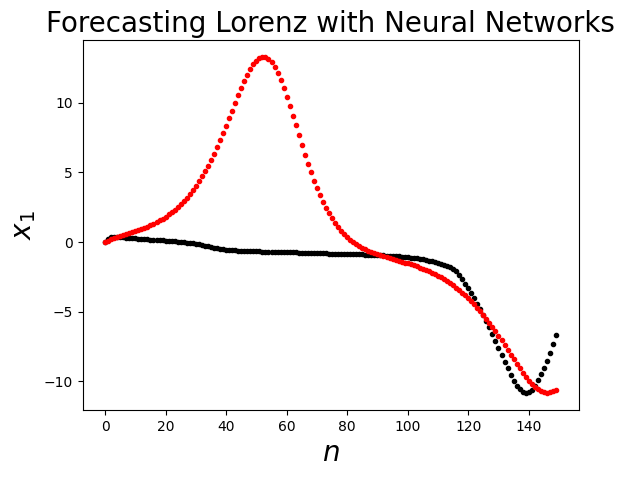

In [ ]:
M = 10000

xpred = np.zeros((M,4))
xpred[0] = dataRho17[0,:]

for m in range(1,M):
    xpred[m] = model(xpred[m-1:m,:])   
    
#Plot Henon Trajectories for rho 17
fig = plt.figure()
plt.plot(xpred[:150,0],'k.') 
plt.plot(dataRho17[:150,0],'r.') 
plt.title('Forecasting Lorenz with Neural Networks', fontsize = 20)
plt.xlabel('$n$', fontsize = 20)
plt.ylabel('$x_1$', fontsize = 20)
plt.savefig("forecast5")

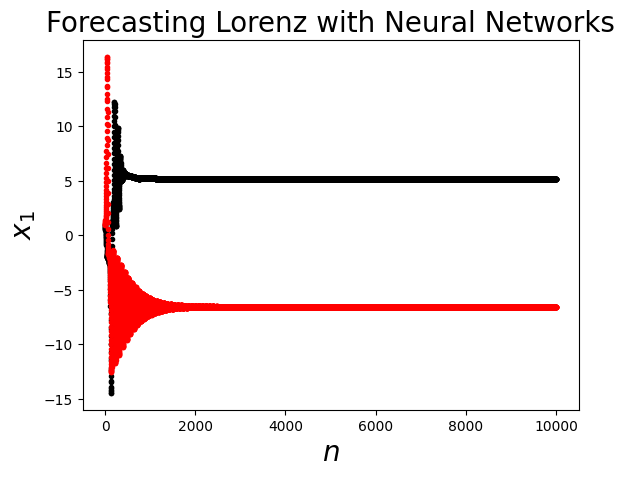

In [ ]:
#Plot Henon Trajectories
fig = plt.figure()
plt.plot(xpred[:10000,1],'k.') 
plt.plot(dataRho17[:10000,1],'r.') 
plt.title('Forecasting Lorenz with Neural Networks', fontsize = 20)
plt.xlabel('$n$', fontsize = 20)
plt.ylabel('$x_1$', fontsize = 20) 
plt.savefig("forecast6")

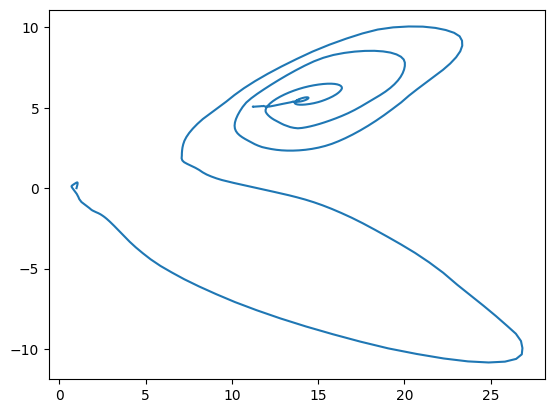

In [ ]:
#Plot of rho 17 data
plt.plot(xpred[:,2], xpred[:, 0], label='x_coord')
plt.savefig("Lorenzrho17data")